In [1]:
import os
import sys

import matplotlib.pyplot as plt

import numpy as np
import torch
import pandas as pd
from train.TrainPNO2D import PNO2D
from heuristics import generaterandompos
from heuristics import euclideannorm, planningoperator, manhattandistance
from heuristics import testheuristiconmaps, testheuristiconsinglemap



Load Test Maps

In [2]:
Ntotal = 550
ntest = 50
ntrain = 250
sub = 1
Sx = Sy = int(((256 - 1) / sub) + 1)
dataset_dir = '/mountvol2/2D-256-Dataset-0/' #Change directory based on actual location
maps = np.load(dataset_dir+'mask.npy')
maps = maps[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

Load Saved Start and Goal Positions

In [3]:
startpositions = np.load(dataset_dir+'startpositions.npy')
goalpositions = np.load(dataset_dir+'goalpositions.npy')

Comparing Euclidean Distance and Manhattan Distance as Heuristics

In [4]:
# Euclidean Norm
print("Testing Euclidean Norm")
euclidean_results = testheuristiconmaps(startpositions, goalpositions, maps, euclideannorm, plotresults=False, printvalues=True)

Testing Euclidean Norm
Average Path Cost: 144.0535626719505 
Average Planning Time: 0.2254512357711792 
Average Number of Node Expansions: 3310.18 
Average Success Rate: 1.0


Planning Operator

In [5]:
# Model
modes = 5
width = 8
nlayers = 1

model = PNO2D(modes, modes, width, nlayers)
model.load_state_dict(torch.load("trained_models/model256.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/tmp/ipykernel_3965/4261087655.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(dataset_dir+'planningoperator_street_maps_256x256_5m_8w_1

PlanningOperator2D(
  (fc0): Linear(in_features=2, out_features=8, bias=True)
  (conv0): SpectralConv2d()
  (w0): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=8, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

With Erosion

In [6]:
no_results = testheuristiconmaps(startpositions, goalpositions, maps, planningoperator, plotresults=False, printvalues=True, erosion = 15, model=model)

Average Path Cost: 144.0535626719505 
Average Planning Time: 0.1381246852874756 
Average Number of Node Expansions: 2024.34 
Average Success Rate: 1.0


No Erosion

In [7]:
no_results = testheuristiconmaps(startpositions, goalpositions, maps, planningoperator, plotresults=False, printvalues=True, erosion = 1, model=model)

Average Path Cost: 144.88919759056088 
Average Planning Time: 0.1359251070022583 
Average Number of Node Expansions: 1757.4 
Average Success Rate: 1.0


100%|██████████| 29/29 [00:10<00:00,  2.72it/s]


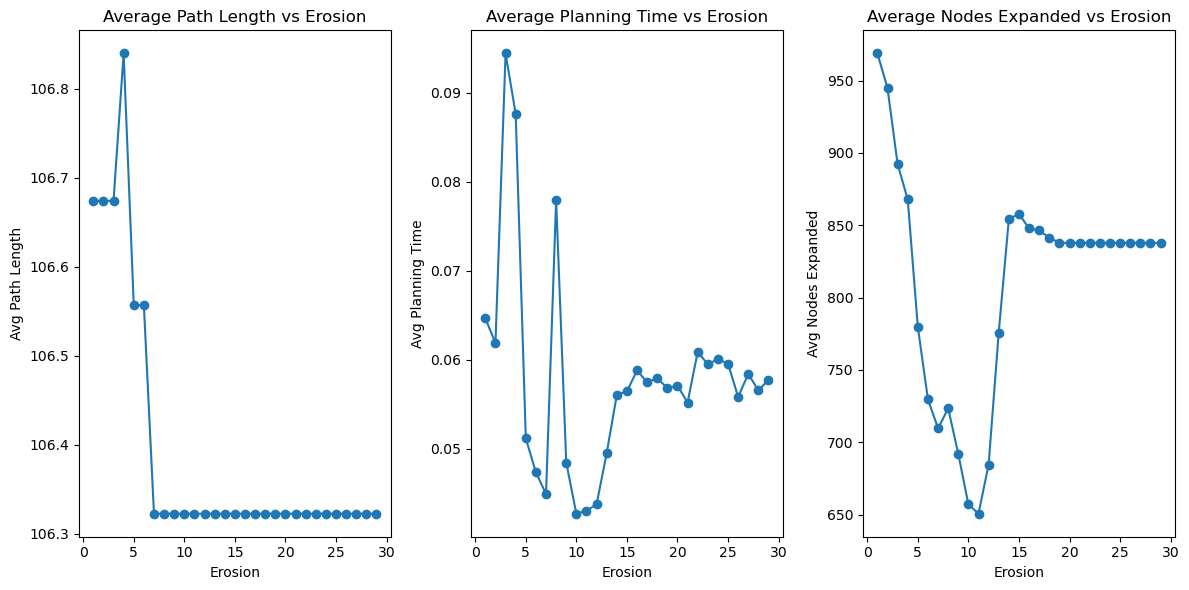

In [8]:
from tqdm import tqdm 

erosionmaps = maps[::10, :, :]
erosionstartpos = startpositions[::10,:]
erosiongoalpos = goalpositions[::10,:]

erosion_values = []
avgpathcost_values = []
avgplantime_values = []
avginfertime_values = []
avgnodesexp_values = []
avgsuccessrate_values = []

# Run the loop and store results
for erode in tqdm(range(1, 30)):
    
    # Call your function and store the results
    avgpathcost, avgplantime, avginfertime, avgnodesexp, avgsuccessrate = testheuristiconmaps(
        erosionstartpos, erosiongoalpos, erosionmaps, planningoperator, model=model, erosion=erode, plotresults=False, printvalues=False
    )
    
    # Append results to lists
    erosion_values.append(erode)
    avgpathcost_values.append(avgpathcost)
    avgplantime_values.append(avgplantime)
    avginfertime_values.append(avginfertime)
    avgnodesexp_values.append(avgnodesexp)
    avgsuccessrate_values.append(avgsuccessrate)

plt.figure(figsize=(12, 6))

# Plot for avgpathcost (Average Path Length)
plt.subplot(1, 3, 1)
plt.plot(erosion_values, avgpathcost_values, marker='o')
plt.title('Average Path Length vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Path Length')

# Plot for avgplantime (Average Planning Time)
plt.subplot(1, 3, 2)
plt.plot(erosion_values, avgplantime_values, marker='o')
plt.title('Average Planning Time vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Planning Time')

# Plot for avgnodesexp (Average Nodes Expanded)
plt.subplot(1, 3, 3)
plt.plot(erosion_values, avgnodesexp_values, marker='o')
plt.title('Average Nodes Expanded vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Nodes Expanded')

plt.tight_layout()
plt.show()

Check single maps

Plotting Euclidean Norm Results
Average Path Cost: 94.71067811865463 
Average Planning Time: 0.10469985008239746 
Average Number of Node Expansions: 1508.0 
Average Success Rate: 1.0


(94.71067811865463, 0.10469985008239746, 0, 1508.0, 1.0)

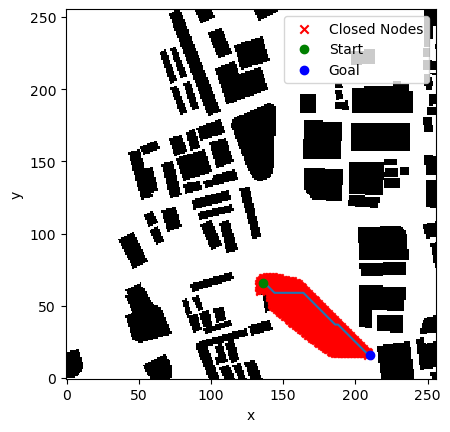

In [9]:
test_case = 5

maptest = maps[test_case,:,:].reshape(1,Sx,Sy)
starttest = startpositions[test_case,:].reshape(1,2)
goaltest = goalpositions[test_case,:].reshape(1,2)
print("Plotting Euclidean Norm Results")
testheuristiconmaps(starttest, goaltest, maptest, euclideannorm, plotresults=True, printvalues=True)

Plotting PNO
Average Path Cost: 94.71067811865467 
Average Planning Time: 0.09568452835083008 
Average Number of Node Expansions: 1368.0 
Average Success Rate: 1.0


(94.71067811865467, 0.09568452835083008, 0, 1368.0, 1.0)

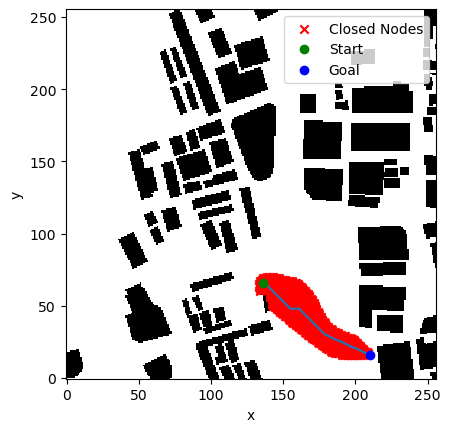

In [10]:
print("Plotting PNO")
maptest = maps[test_case,:,:].reshape(1,Sx,Sy)
starttest = startpositions[test_case,:].reshape(1,2)
goaltest = goalpositions[test_case,:].reshape(1,2)
testheuristiconmaps(starttest, goaltest, maptest, planningoperator, plotresults=True, printvalues=True, erosion = 1, model=model)